### BERT/BioBERT Question-Answering system using CORD-19 dataset

In this notebook, we are finetuning BERT and BioBERT for answering questions related to COVID. We are also visualizing the attention in the intermediate layers between the two models.

We are using the COVID-19 Open Research Dataset (https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge). We find the cosine-similarity between the query and the research articles. The top 20 articles based on cosine-similarity scores are used as contexts in a BERT QA head and an answer is predicted for every context.

### Install the required packages

In [ ]:
!pip install --quiet transformers
!pip install --quiet semanticscholar sentence_transformers
!pip install --quiet captum
!pip install --quiet  evaluate

     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 72.1 MB/s 
     |████████████████████████████████| 182 kB 88.2 MB/s 
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 1.3 MB 8.8 MB/s 
     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 132 kB 8.9 MB/s 
     |████████████████████████████████| 212 kB 52.1 MB/s 
     |████████████████████████████████| 451 kB 110.8 MB/s 
     |████████████████████████████████| 127 kB 110.8 MB/s 


In [ ]:
!pip install --q Ipython --upgrade
#from transformers import BertConfig, BertModel

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 761 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 90.5 MB/s 
     |████████████████████████████████| 386 kB 83.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.7.0 which is incompatible.


In [ ]:
import json
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import base64
import csv
import glob
import json
import re
import semanticscholar as sch
from IPython.display import display, Latex, HTML
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModel
import evaluate

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# for visualizing attention
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DL_CovidQA/')

In [ ]:
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except:
    pass

Mounted at /content/drive


In [ ]:
from viz import *
from eval import *
from retrieval import *

### Data Preprocessing

In [ ]:
# Adapted from: "TF-IDF Cosine Simlarity & BERT- task 6" on Kaggle (Nov 19 2019)
# https://www.kaggle.com/code/tizili0307/tf-idf-cosine-simlarity-bert-task-6

# run directly on kaggle for easier access of data

# import os
# import re
# import nltk
# import json
# import torch
# import nltk.corpus  
# import pandas as pd
# import numpy as np
# 
# from tqdm import tqdm
# from pathlib import Path
# from copy import deepcopy
# from fuzzywuzzy import fuzz 
# from nltk.stem import PorterStemmer
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import TfidfVectorizer
# 
# !pip install transformers
# from transformers import BertForQuestionAnswering
# from transformers import BertTokenizer
# 
# nltk.download('punkt')
# nltk.download('stopwords')
# 
# pd.set_option('display.max_colwidth', None)
# pd.options.display.max_rows = 999
#
#
# def format_name(author):
#    """
#    Convert first name, middle name, and last name to full name
#    
#    :param authors: a dictionary - first name, middle name, last name
#
#    :return: full name with combined first name, middle name (if existing) and last name 
#    """
#    middle_name = " ".join(author['middle'])
#    if author['middle']:
#        return " ".join([author['first'], middle_name, author['last']])
#    else:
#        return " ".join([author['first'], author['last']])
#		
#
# def format_affiliation(affiliation):
#    text = []
#    location = affiliation.get('location')
#    if location:
#        text.extend(list(affiliation['location'].values()))
#
#    institution = affiliation.get('institution')
#    if institution:
#        text = [institution] + text
#    return ", ".join(text)
#	
#
# def format_authors(authors, with_affiliation=False):
#    """
#    Convert first name, middle name, and last name to full name
#    
#    :param authors: a dictionary - first name, middle name, last name
#
#    :return: full name with combined first name, middle name (if existing) and last name 
#    """
#    name_ls = []
#
#    for author in authors:
#        name = format_name(author)
#        if with_affiliation:
#            affiliation = format_affiliation(author['affiliation'])
#            if affiliation:
#                name_ls.append(f"{name} ({affiliation})")
#            else:
#                name_ls.append(name)
#        else:
#            name_ls.append(name)
#
#    return ", ".join(name_ls)
#
#
# def format_body(body_text):
#    texts = [(di['section'], di['text']) for di in body_text]
#    texts_di = {di['section']: "" for di in body_text}
#
#    for section, text in texts:
#        texts_di[section] += text
#
#    body = ""
#
#    for section, text in texts_di.items():
#        body += section
#        body += "\n\n"
#        body += text
#        body += "\n\n"
#
#    return body
#
#
# def format_bib(bibs):
#    if type(bibs) == dict:
#        bibs = list(bibs.values())
#    bibs = deepcopy(bibs)
#    formatted = []
#
#    for bib in bibs:
#        bib['authors'] = format_authors(
#            bib['authors'],
#            with_affiliation=False
#        )
#        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
#        formatted.append(", ".join(formatted_ls))
#
#    return "; ".join(formatted)

# def load_files(dirname):
#    filenames = os.listdir(dirname)
#    raw_files = []
#
#    for filename in tqdm(filenames):
#        filename = dirname + filename
#        file = json.load(open(filename, 'rb'))
#        raw_files.append(file)
#
#    return raw_files

# def clean_pdf_files(file_list, keyword_list):
#    nth_paper=0
#    cleaned_files=[]
#    for file in file_list:
#        with open(file) as f:
#            file=json.load(f)
#        features = [
#            file['paper_id'],
#            file['metadata']['title'],
#            format_authors(file['metadata']['authors']),
#            format_authors(file['metadata']['authors'],
#                           with_affiliation=True),
#            format_body(file['abstract']),
#            format_body(file['body_text']),
#            format_bib(file['bib_entries']),
#            file['metadata']['authors'],
#            file['bib_entries']
#        ]
#        if(nth_paper%1000)==0:
#            print(nth_paper)
#        nth_paper=nth_paper+1
#
#        has_keyword = False
#        for keyword in keyword_list:
#            if keyword in features[5]:
#                has_keyword = True
#                break
#        if has_keyword == True:
#            cleaned_files.append(features)
#    col_names = ['paper_id', 'title', 'authors',
#                 'affiliations', 'abstract', 'text',
#                 'bibliography','raw_authors','raw_bibliography']
#    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
#    return clean_df




# assign the path of the paper collections provided by Kaggle
# path = '/kaggle/input/CORD-19-research-challenge/document_parses/pdf_json'
# file_list = [os.path.join(r, file)  for r, _, f in os.walk(path)  for file in f] # Convert the collections to a list




# set keywords to filter the papers relevant to COVID-19
# keyword_list = ['novel coronavirus', 'novel-coronavirus', 'coronavirus-2019', 
#                'sars-cov-2', 'sarscov2', 'covid-19', 'covid19',
#                '2019ncov', '2019-ncov', 'wuhan']



# clean the papers
# clean_pdf_df = clean_pdf_files(file_list, keyword_list)

### Read the preprocessed data

In [ ]:
df_covid = pd.read_csv("/content/drive/MyDrive/DL_CovidQA/clean_covid_df.csv")

In [ ]:
len(df_covid)

44306

In [ ]:
df_covid.head()

,Unnamed: 0,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography,doi,publish_time,journal,text_cleaned
0,0,89afc7a375be1b21ee163ab5877961e19a501638,"Mask usage, social distancing, racial, and gen...","Carl A Latkin Id, Lauren Dayton, Grace Yi, Bri...","Carl A Latkin Id (Johns Hopkins University, Ba...",Abstract\n\nVaccine hesitancy could become a s...,Introduction\n\nThe death toll of COVID-19 cas...,A country level analysis measuring the impact ...,"[{'first': 'Carl', 'middle': ['A'], 'last': 'L...","{'BIBREF0': {'ref_id': 'b0', 'title': 'A count...",10.1371/journal.pone.0246970,2021-02-16,PLoS One,introduct death toll case fail pandem prepared...
1,1,75223a559e84de617bd57848b99734d9d2b3e10d,Journal Pre-proof A modified theory of planned...,"Pahrudin Pahrudin, Chien-Ting Chen, Li-Wei Liu",Pahrudin Pahrudin (Chaoyang University of Tech...,Abstract\n\nThe Pandemic covid-19 spread globa...,Introduction\n\nTourism is one of many sectors...,A/H1N1 Vaccine Intentions in College Students:...,"[{'first': 'Pahrudin', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'A/H1N1 ...",10.1016/j.heliyon.2021.e08230,2021-10-21,Heliyon,introduct tourism one mani sector affect eithe...
2,2,f1e5e8efb7936576cf24083e9db2f21158b9de28,Lipopeptides against COVID-19 RNA-dependent RN...,"Q5 Q4, Bo Xia, Minyi Luo, Li Pang, Xia Liu, Yo...","Q5 Q4, Bo Xia (Hunan Agricultural University, ...",Abstract\n\na b s t r a c t Q1 Aims: Coronavir...,"\n\nCOVID -19) have been developed, uncertaint...","SARS-CoV-2, the angiotensin converting enzyme ...","[{'first': 'Q5', 'middle': [], 'last': 'Q4', '...","{'BIBREF0': {'ref_id': 'b0', 'title': ""SARS-Co...",NaN,NaN,NaN,covid uncertainti protect breakthrough infect ...
3,3,2c608a7a776af1590b0d4052fbc86cfb04649247,Radiomics Analysis of Computed Tomography help...,"Qingxia Wu, Shuo Wang, Liang Li, Wei Qian, Yah...",Qingxia Wu (People's Hospital of Zhengzhou Uni...,Abstract\n\nGiven the rapid spread of COVID-19...,Introduction\n\nAn ongoing outbreak of coronav...,Clinical features of patients infected with 20...,"[{'first': 'Qingxia', 'middle': [], 'last': 'W...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Clinica...",10.7150/thno.46428,2020-06-05,Theranostics,introduct ongo outbreak coronaviru diseas asso...
4,4,ddd596a5c31a48e0efa95b814e4fe7726abfb25c,Personality Traits and Changes in Health Behav...,"Tiia Kekäläinen, Enni-Maria Hietavala, Matti H...","Tiia Kekäläinen (University of Jyväskylä, Raut...","Abstract\n\nCitation: Kekäläinen, T.; Hietaval...",Introduction\n\nThe novel coronavirus disease ...,COVID-19 Operationalization of the Global Resp...,"[{'first': 'Tiia', 'middle': [], 'last': 'Kekä...","{'BIBREF0': {'ref_id': 'b0', 'title': 'COVID-1...",10.3390/ijerph18157732,2021-07-21,Int J Environ Res Public Health,introduct novel coronaviru diseas discov end r...


### TF-IDF and cosine similarity

In [ ]:
# set text
text_cleaned = df_covid['text_cleaned']

In [ ]:
text_cleaned

0        introduct death toll case fail pandem prepared...
1        introduct tourism one mani sector affect eithe...
2        covid uncertainti protect breakthrough infect ...
3        introduct ongo outbreak coronaviru diseas asso...
4        introduct novel coronaviru diseas discov end r...
                               ...                        
44301    introduct recent outbreak coronaviru diseas ca...
44302    introduct coronaviru diseas infecti diseas cau...
44303    share price three largest cruis oper januari s...
44304    background novel coronaviru name sever acut re...
44305    introduct itali entir world current face chall...
Name: text_cleaned, Length: 44306, dtype: object

#### Read COVID QA data for queries

In [ ]:
!pip install --quiet datasets
from datasets import load_dataset

In [ ]:
train_data = load_dataset("covid_qa_deepset", split='train[:90%]')
val_data = load_dataset("covid_qa_deepset",split='train[90%:]') 

train_contexts, train_questions, train_answers = train_data["context"], train_data["question"], train_data["answers"]
val_contexts, val_questions, val_answers = val_data["context"], val_data["question"], val_data["answers"]

Generating train split:   0%|          | 0/2019 [00:00<?, ? examples/s]

Dataset covid_qa_deepset downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_deepset/covid_qa_deepset/1.0.0/fb886523842e312176f92ec8e01e77a08fa15a694f5741af6fc42796ee9c8c46. Subsequent calls will reuse this data.


### BERT base Without Fine-tuning

In [ ]:
# selecting most covid-related questions for validation
val_questions_cov = []
idxs = []
for i in range(len(val_questions)):
  if 'covid' in val_questions[i].lower():
    val_questions_cov.append(val_questions[i])
    idxs.append(i)

In [ ]:
val_contexts_cov = [val_contexts[i] for i in idxs]
val_answers_cov = [val_answers[i] for i in idxs]

In [ ]:
val_questions_cov

['Where was COVID19 first discovered?',
 'How does being a smoker impact COVID-19 patient outcomes?',
 'Why might we underestimate the spread of COVID19?',
 'Where was the first imported case of COVID19 in the United States?',
 'When was the first case of COVID19 confirmed in the USA?',
 'When was the second COVID19 case reported in the US?',
 'Where was the second reported case of COVID in the United States?',
 'When was the first local transmission of COVID reported in the United States?',
 'When did the WHO declare COVID to be a Public Health Emergency of International Concern?',
 'When did the United States declare COVID19 a public health emergency?',
 'What are the most common symptoms of COVID19?',
 'What symptoms might people experience with COVID19?',
 'Who is at greater risk of dying from COVID19?',
 'How long is the incubation time for COVID19?',
 'How does COVID19 get spread?',
 'Is it possible to get infected with COVID and another virus?']

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("kaporter/bert-base-uncased-finetuned-squad")
#model = AutoModelForQuestionAnswering.from_pretrained("kaporter/bert-base-uncased-finetuned-squad", output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad", output_attentions=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

In [ ]:
# for computing similarity scores
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# METEOR Test
ans = train_answers[0]['text']
preds = ['HIV-1 infection is not caused by mother to-child transmission.']

meteor.compute(predictions=preds, references=ans)['meteor']

0.27687590187590183

In [ ]:
# Segment our documents
docs = df_covid['text']
segmented_docs = segment_documents(docs, 450)

In [ ]:
# checking for 1 question, example 1
question = val_questions_cov[10]
print(question)

What are the most common symptoms of COVID19?


In [ ]:
k = 20
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[CLS]
[CLS]
[CLS]
mild hypoxemia with preserved lung compliance , and a mild inflammatory response
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
dyspnea , fever , thrombocytopenia , abnormal liver function , vomiting
[CLS]
[CLS]
Fever , dry cough , and exhaustion
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
asymptomatic or having mild respiratory symptoms


In [ ]:
answer = val_answers_cov[10]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.0
0.12820512820512822
0.0
0.0
0.0
0.0
0.0
0.13157894736842107
0.0
0.0
0.44117647058823534
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
print(answer)

Fever and cough


In [ ]:
# checking for 1 question, example 2
question = val_questions_cov[13]
print(question)

How long is the incubation time for COVID19?


In [ ]:
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

[CLS]
[CLS]
2 . 87 days [ 3 ] to 17 . 6 days
[CLS]
[CLS]
[CLS]
The
The
[CLS]
[CLS]
7 . 5 days
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
4


In [ ]:
answer = val_answers_cov[13]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.17543859649122806
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.10204081632653061
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
print(answer)

between 2 and 14 days


In [ ]:
# Enter our query here
#query = "What else does the bassist for Death From Above play?"

def run_eval():
  meteor_total = 0
  pred_ans = []

  # Return the likeliest answers from each of our top k most relevant documents in descending order
  for i in range(len(val_questions_cov)):
    # Retrieve the top k(=1) most relevant documents to the query
    candidate_docs = get_top_k_articles(val_questions_cov[i], segmented_docs, 20)
    pred = []
    score = []
    for j in range(len(candidate_docs)):
      pred.append(answer_question(model, tokenizer, val_questions_cov[i], candidate_docs[j],device))
      score.append(meteor.compute(predictions=[pred[-1]], references=val_answers_cov[i]['text'])['meteor'])
    pred_ans.append(pred[score.index(max(score))])
    meteor_total += max(score)
    #meteor_total += meteor.compute(predictions=[pred], references=val_answers_cov[i+10]['text'])['meteor']

  return pred_ans, meteor_total / len(val_questions_cov)

answer_pred, meteor_score = run_eval()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### Visualizing Attention scores 

For 1 question - "What are the most common symptoms of COVID19?"

Visualizing the attention matrices for one of the layers, layer 1

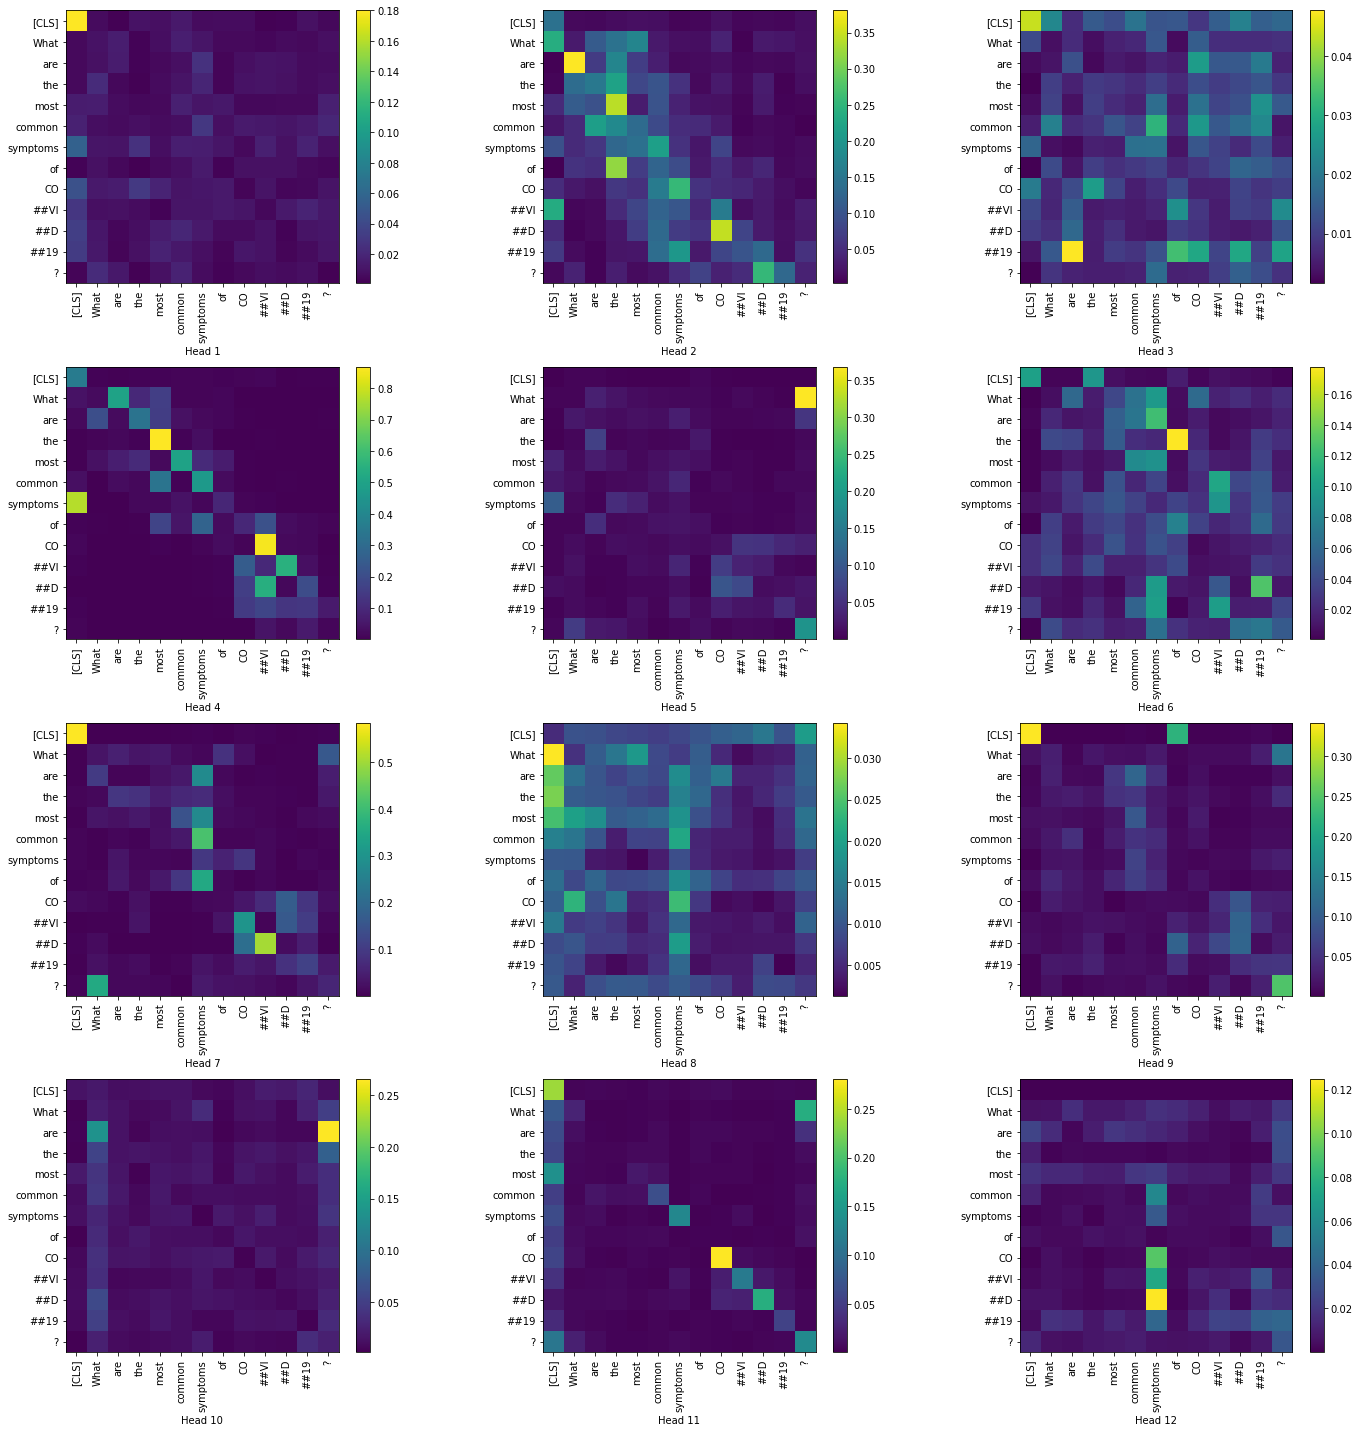

In [ ]:
answer = val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], candidate_doc[12], answer, 512, tokenizer, model, device)
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

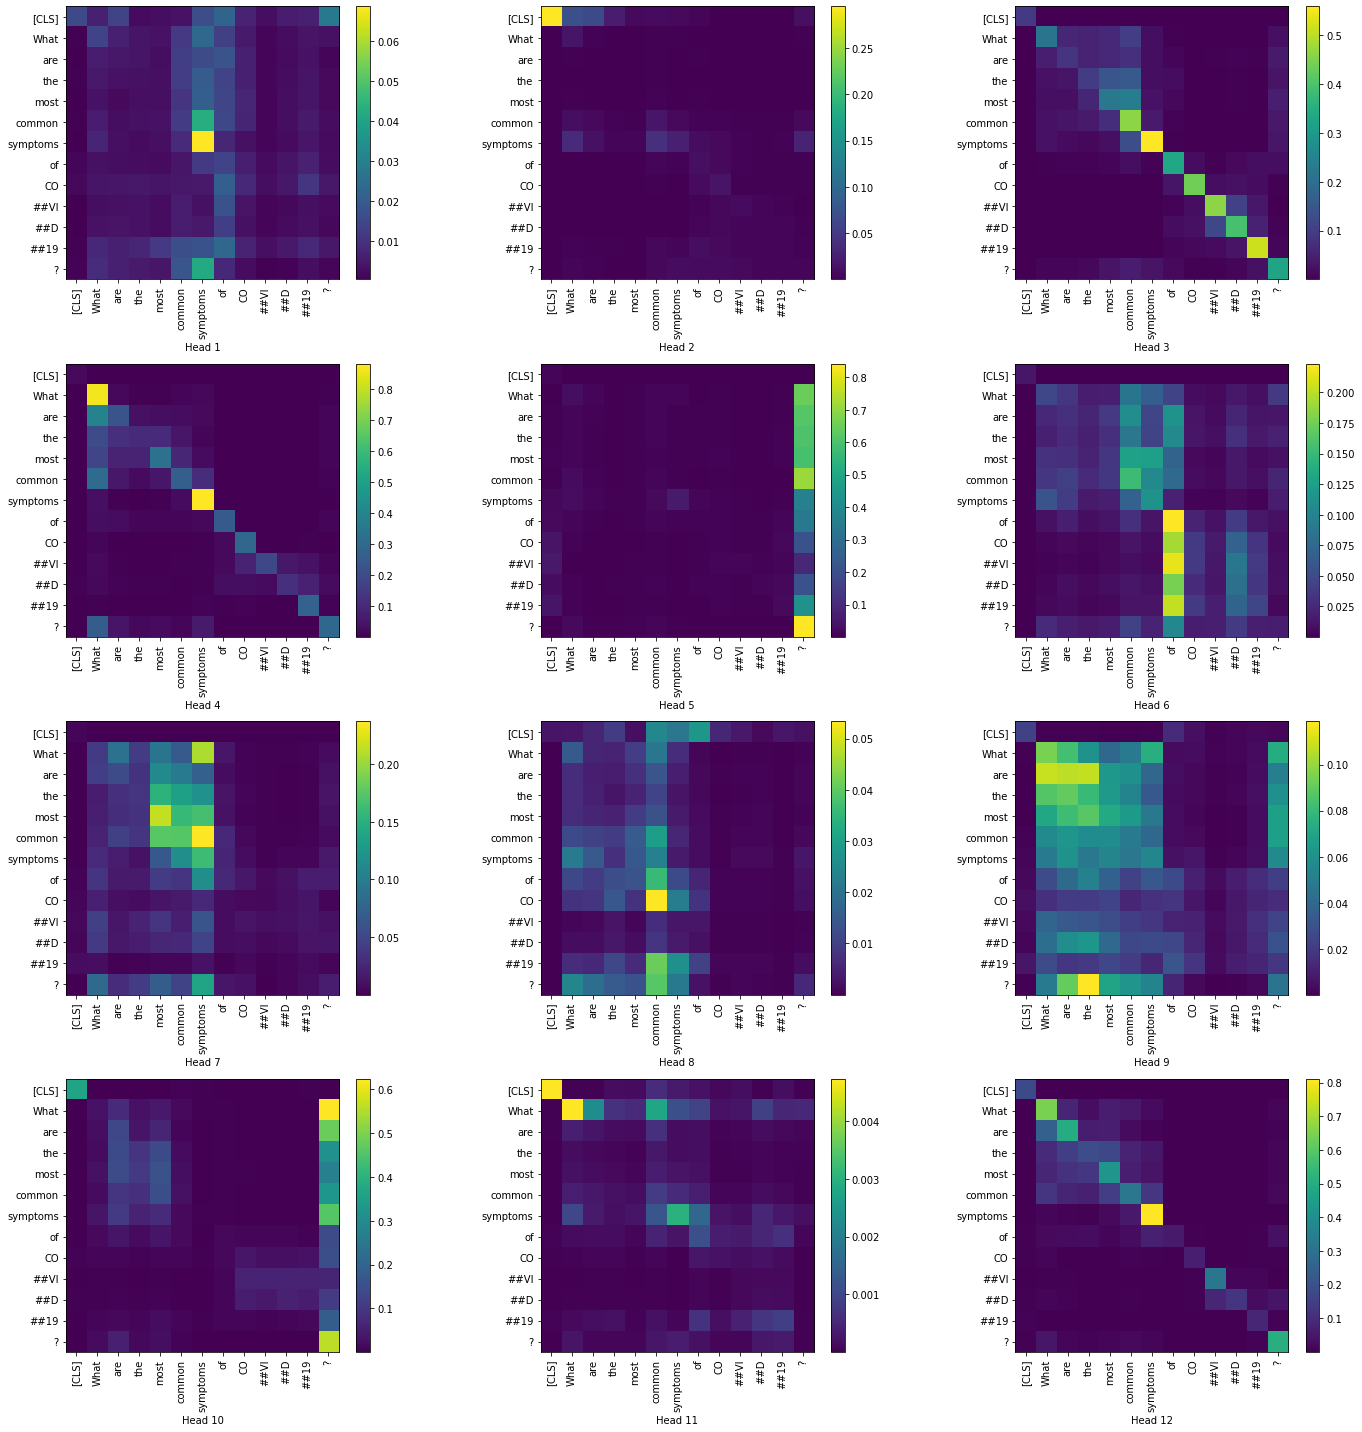

In [ ]:
answer = val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], candidate_doc[12], answer, 512, tokenizer, model, device)
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

Visualizing a summary for each layer across all heads

In [ ]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [ ]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [ ]:
output_attentions_all = torch.stack(attn_score_qn)

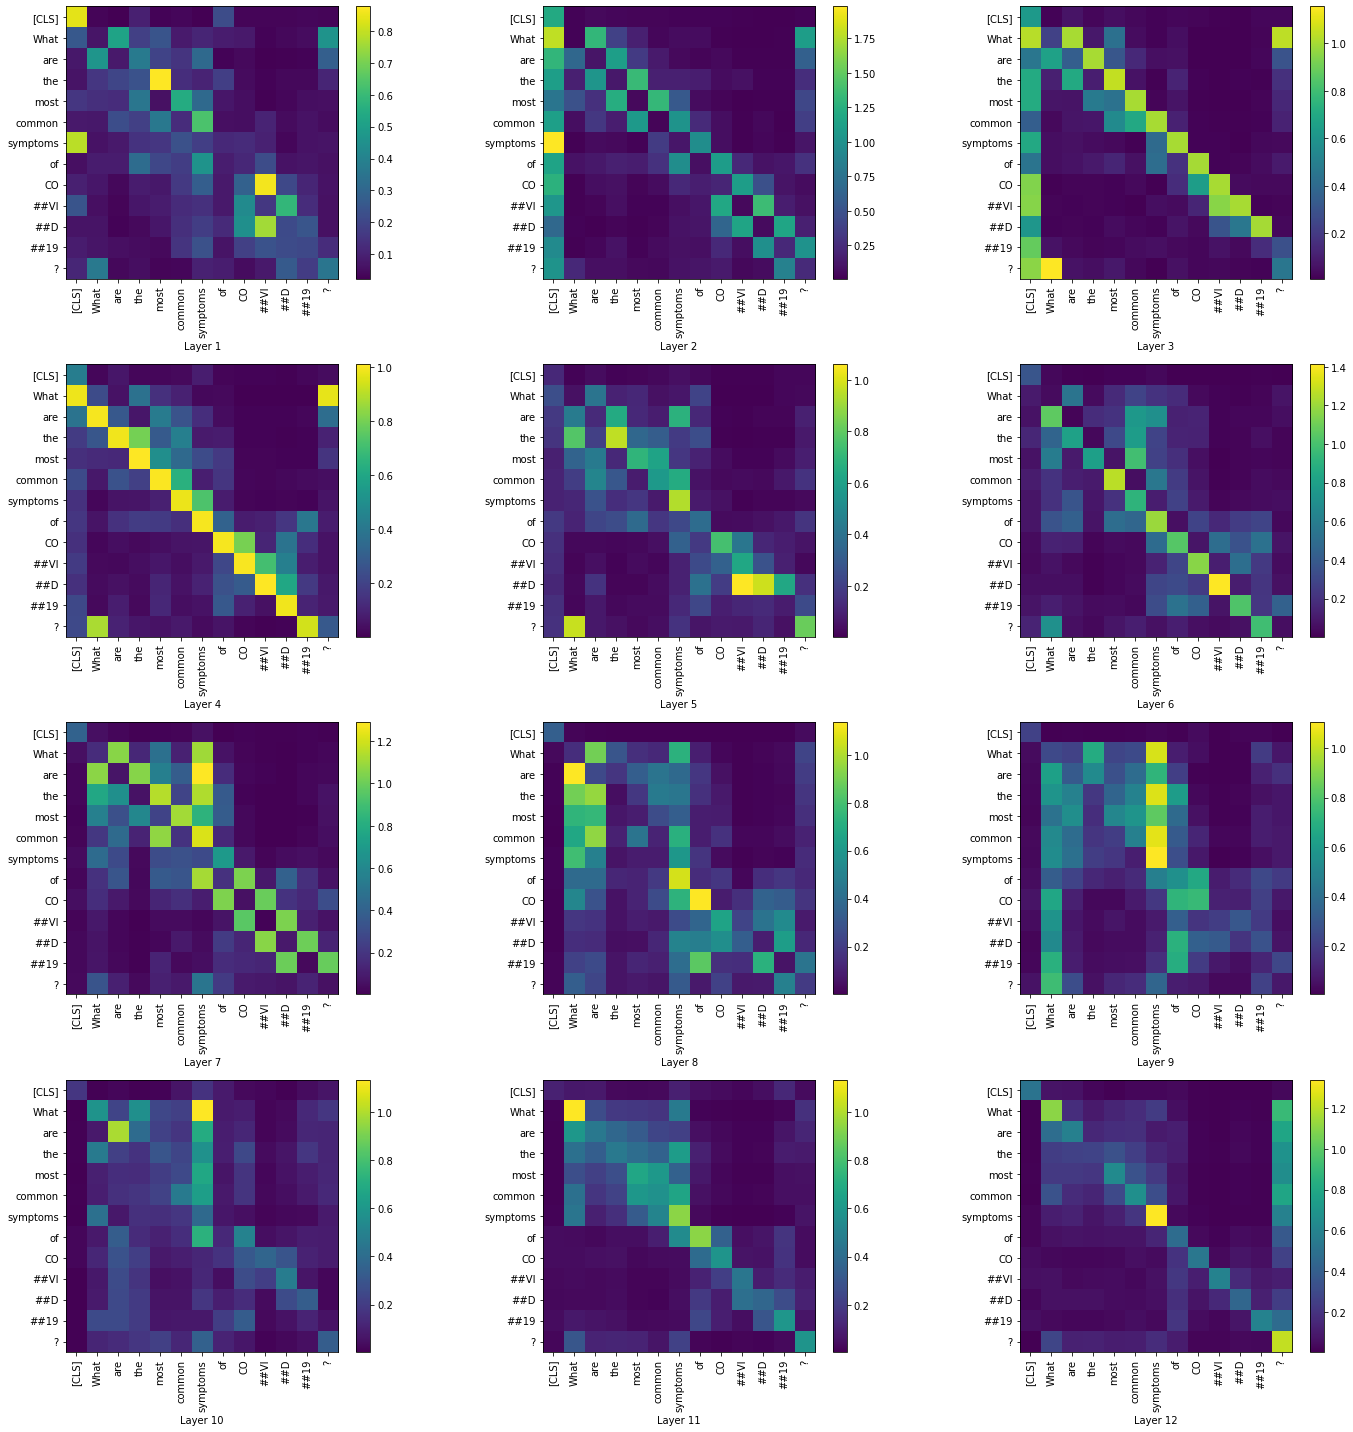

In [ ]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### After fine-tuning

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CovidQA/bert_base_cased_covidqa_finetuned.pt"))

<All keys matched successfully>

In [ ]:
#answer_pred, meteor_score = run_eval()

In [ ]:
# checking for 1 question, example 1
question = val_questions_cov[10]
print(question)

What are the most common symptoms of COVID19?


In [ ]:
k = 20
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

between
[CLS]
What
Trans
Re
What
to ratings of smell and taste loss . This implies acute change in olfactory function for COVID19 positive individuals was not attributable to simple conductive losses
Re
What
severe
three
What
Fever , dry cough , and exhaustion are the most common symptoms of COVID19 . Now the virus has been spread all over the world . As of 28 February 2022 , 446 , 511 , 318 people is effected by the COVID19 with deaths 6 , 004 , 421 . To identify the disease in humans COVID19 reverse transcription - polymerase chain reaction ( RT - PCR ) is used which is time consuming and has a high positive false rate [ 1 , 2 , 4 ] . As of now the significant learning techniques on clinical imaging are the incredible strategy for dealing with the medical diagnosis systems . Computer - Aided Diagnosis methods such as chest X - ray and Computed Tomography techniques can be used as a complement for RT - PCR [ 5 ] . For the diagnosis of lung infections , CT and chest X - ray images
tran

In [ ]:
answer = val_answers_cov[10]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.0
0.0
0.0
0.0
0.09433962264150944
0.0
0.0
0.0
0.0
0.0
0.08241758241758243
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
# checking for 1 question, example 2
question = val_questions_cov[13]
print(question)

How long is the incubation time for COVID19?


In [ ]:
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

between
[CLS]
2 . 87 days
≤ 0 . 1 and a nominal p - value of ≤ 0 . 01 to select genes sets for network analysis . Figure 5 highlights the top network clusters and key biological processes that were differentially regulated in COVID19 + vs . COVID19− ICU patients . Notable clusters / processes identified as being either positively or negatively enriched in COVID19 + ICU patients by these analyses included platelet activation ( 20 gene sets ) , neurotrophin signalling ( 29 gene sets ) , SUMOylation and ubiquitination of proteins ( 27
Re
31 - 40 % with a median of 9 days
days
16 . 5 million people globally have caught the virus , of whom more than 650 , 000 have died . The novel virus , causing severe acute respiratory disease , is thought to be from the same family as Middle East Respiratory Syndrome ( MERS ) coronavirus and Severe Acute Respiratory Syndrome ( SARS ) coronavirus , but it is unique in its own right . This means that central epidemiological parameters , which include the i

In [ ]:
answer = val_answers_cov[13]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.10869565217391304
0.0
0.20408163265306123
0.03676470588235295
0.0
0.09090909090909091
0.10869565217391304
0.10181451612903228
0.08888888888888889
0.05665722379603401
0.0
0.052447552447552455
0.0
0.0
0.0
0.0
0.10638297872340426
0.18867924528301888
0.09615384615384616
0.10869565217391304


#### Visualizing Attention scores

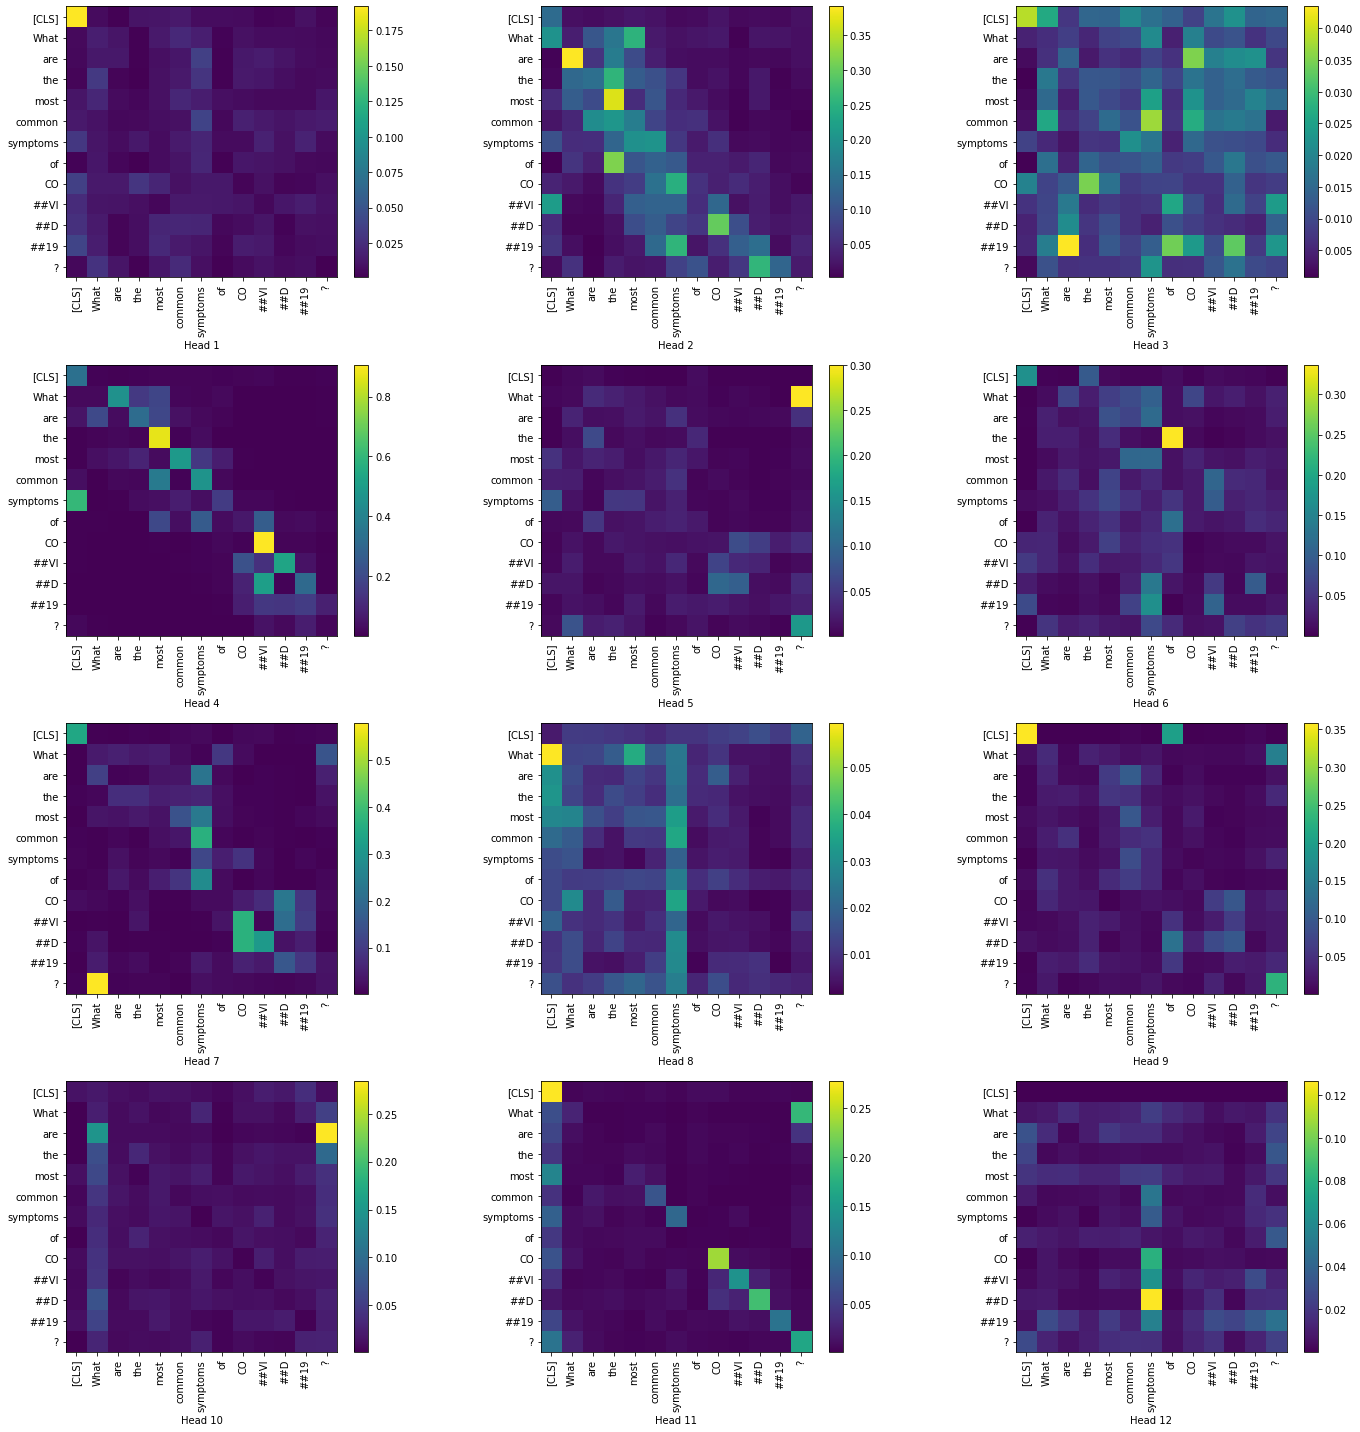

In [ ]:
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], candidate_doc[12], answer, 512, tokenizer, model, device)
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

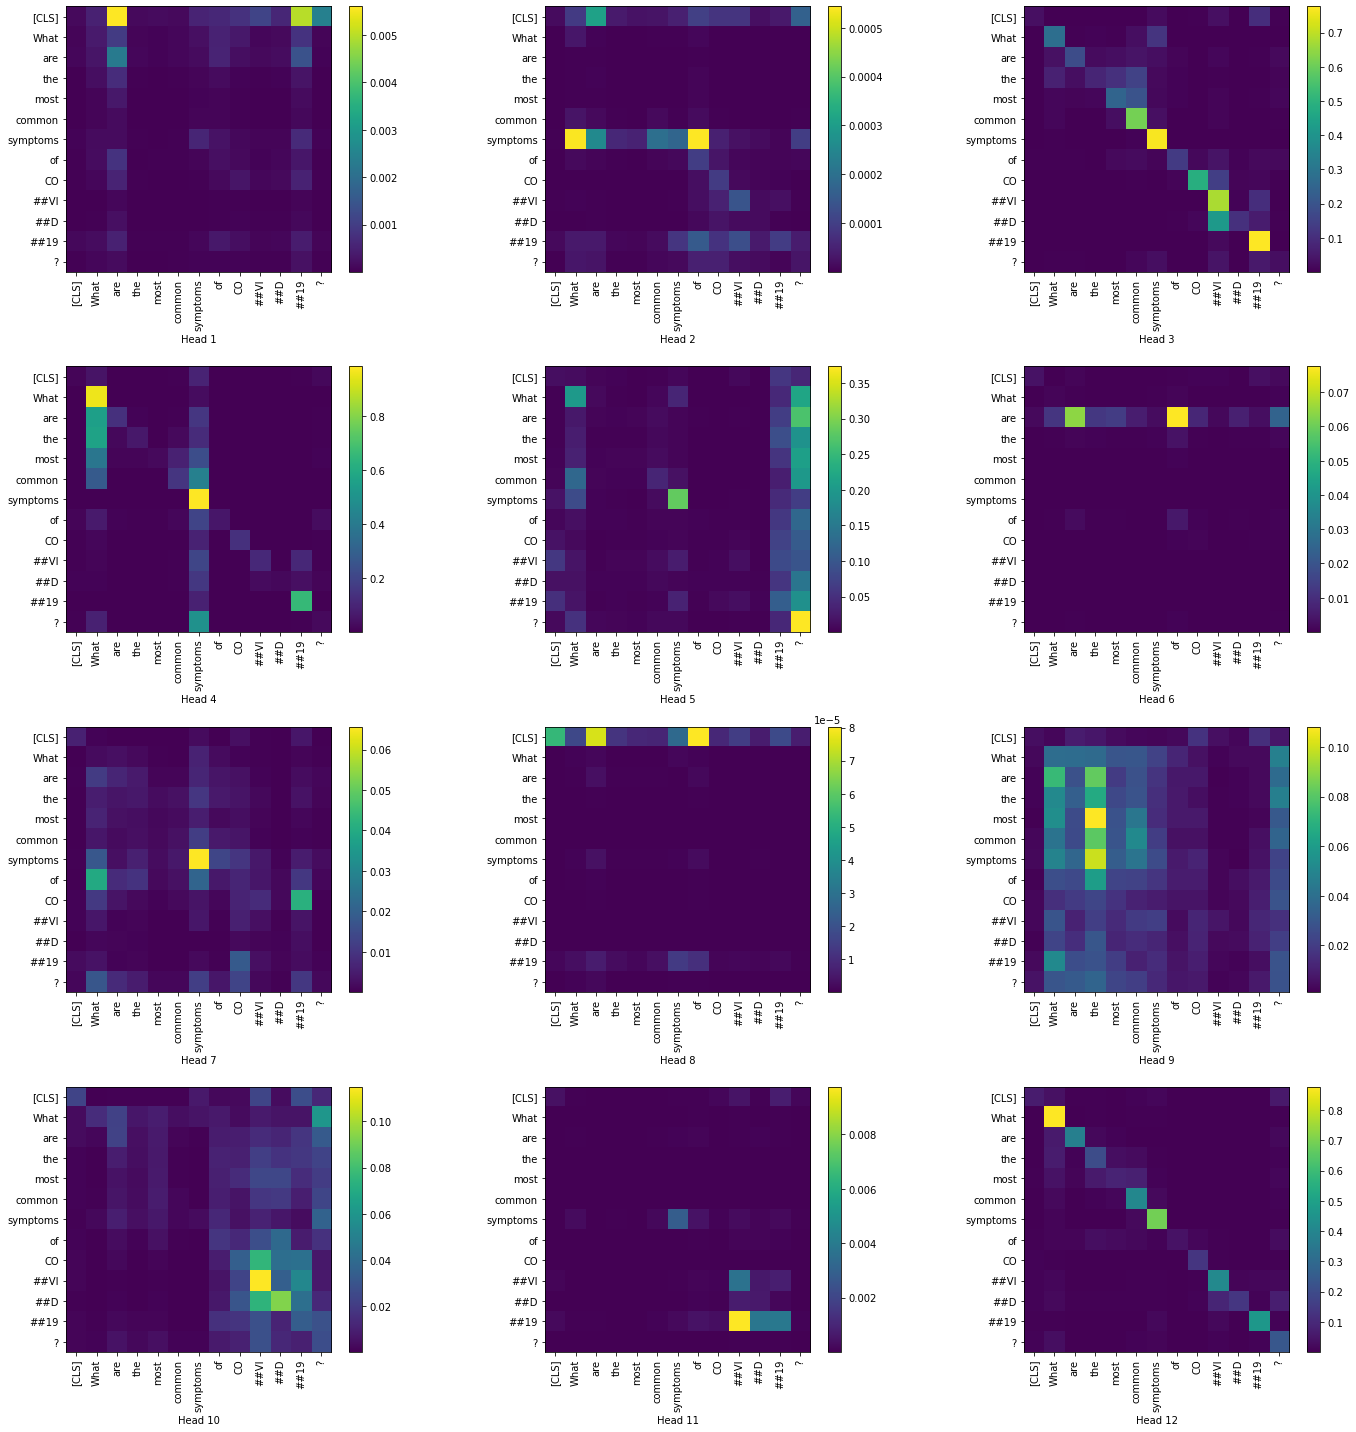

In [ ]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [ ]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [ ]:
output_attentions_all = torch.stack(attn_score_qn)

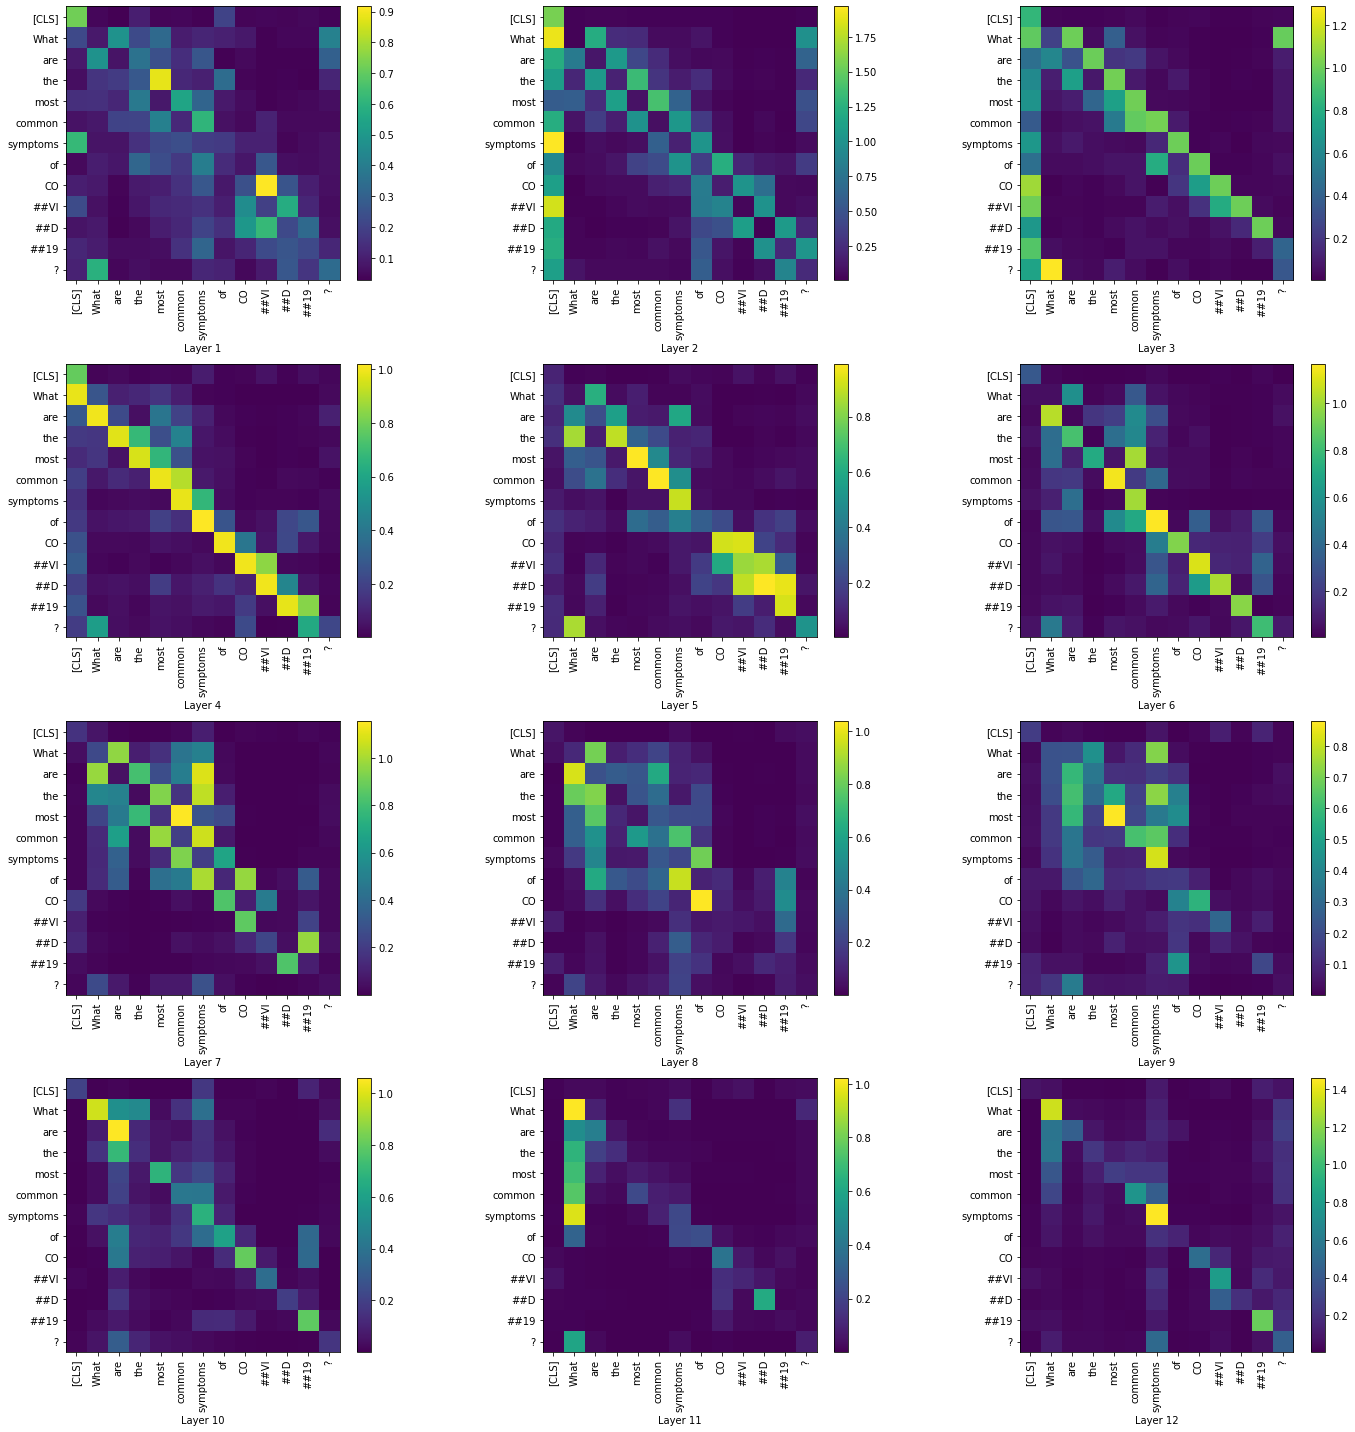

In [ ]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

## With BioBERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad", output_attentions=True)

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)

### Without Fine-tuning

In [ ]:
#answer_pred, meteor_score = run_eval()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# checking for 1 question, example 1
question = val_questions_cov[10]
print(question)

What are the most common symptoms of COVID19?


In [ ]:
k = 20
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[CLS]
[CLS]
[CLS]
mild
[CLS]
[CLS]
smell and taste loss
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
Fever , dry cough , and exhaustion
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
[CLS] What are the most common symptoms of COVID19 ? [SEP] INTRODUCTION The novel coronavirus pandemic , SARS - COV - 2 ( COVID19 ) , has become a significant concern due to its high mortality rate and unknown nature . Although this virus typically involves the respiratory tract , other organs are also involved with extrapulmonary manifestations ( 1 , 2 ) . The clinical manifestations range from being asymptomatic or having mild respiratory symptoms to having severe life - threatening respiratory and heart failure


In [ ]:
answer = val_answers_cov[10]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.0
0.0
0.0
0.0
0.16129032258064518
0.0
0.0
0.0
0.0
0.0
0.44117647058823534
0.0
0.0
0.0
0.0
0.0
0.0
0.04273504273504274


In [ ]:
# checking for 1 question, example 2
question = val_questions_cov[13]
print(question)

How long is the incubation time for COVID19?


In [ ]:
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

4
[CLS]
2 . 87 days [ 3 ] to 17 . 6 days
[CLS]
[CLS]
[CLS]
[CLS]
[CLS]
6 . 0 days
14 days
7 . 5 days
4 . 75 days
[CLS]
three weeks with a very marginal increment . For the final two weeks
[CLS]
[CLS]
[CLS]
[CLS]
5
6


In [ ]:
answer = val_answers_cov[13]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.17543859649122806
0.0
0.0
0.0
0.0
0.0
0.10204081632653061
0.39893617021276595
0.10204081632653061
0.10204081632653061
0.0
0.08620689655172414
0.0
0.0
0.0
0.0
0.0
0.0


#### Visualizing Attention - BioBERT with No Finetuning on COVID-QA

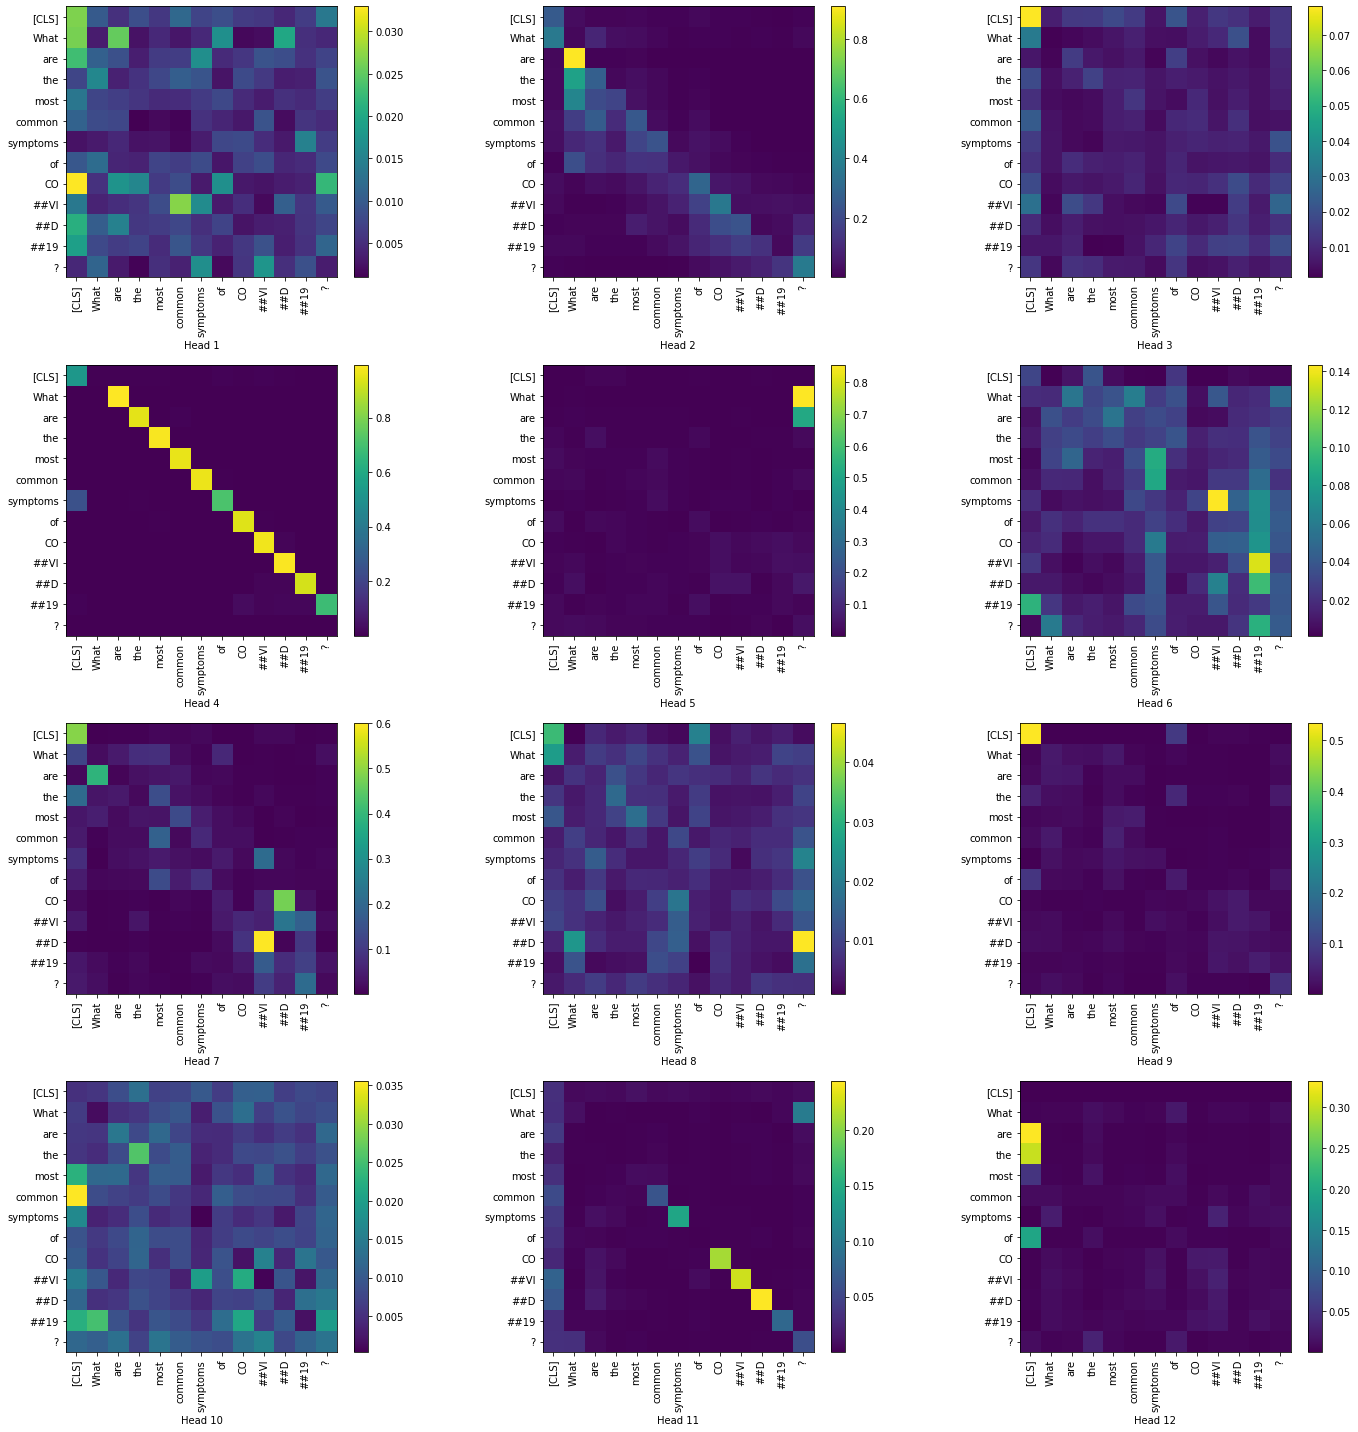

In [ ]:
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], candidate_doc[12], answer, 512, tokenizer, model, device)
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

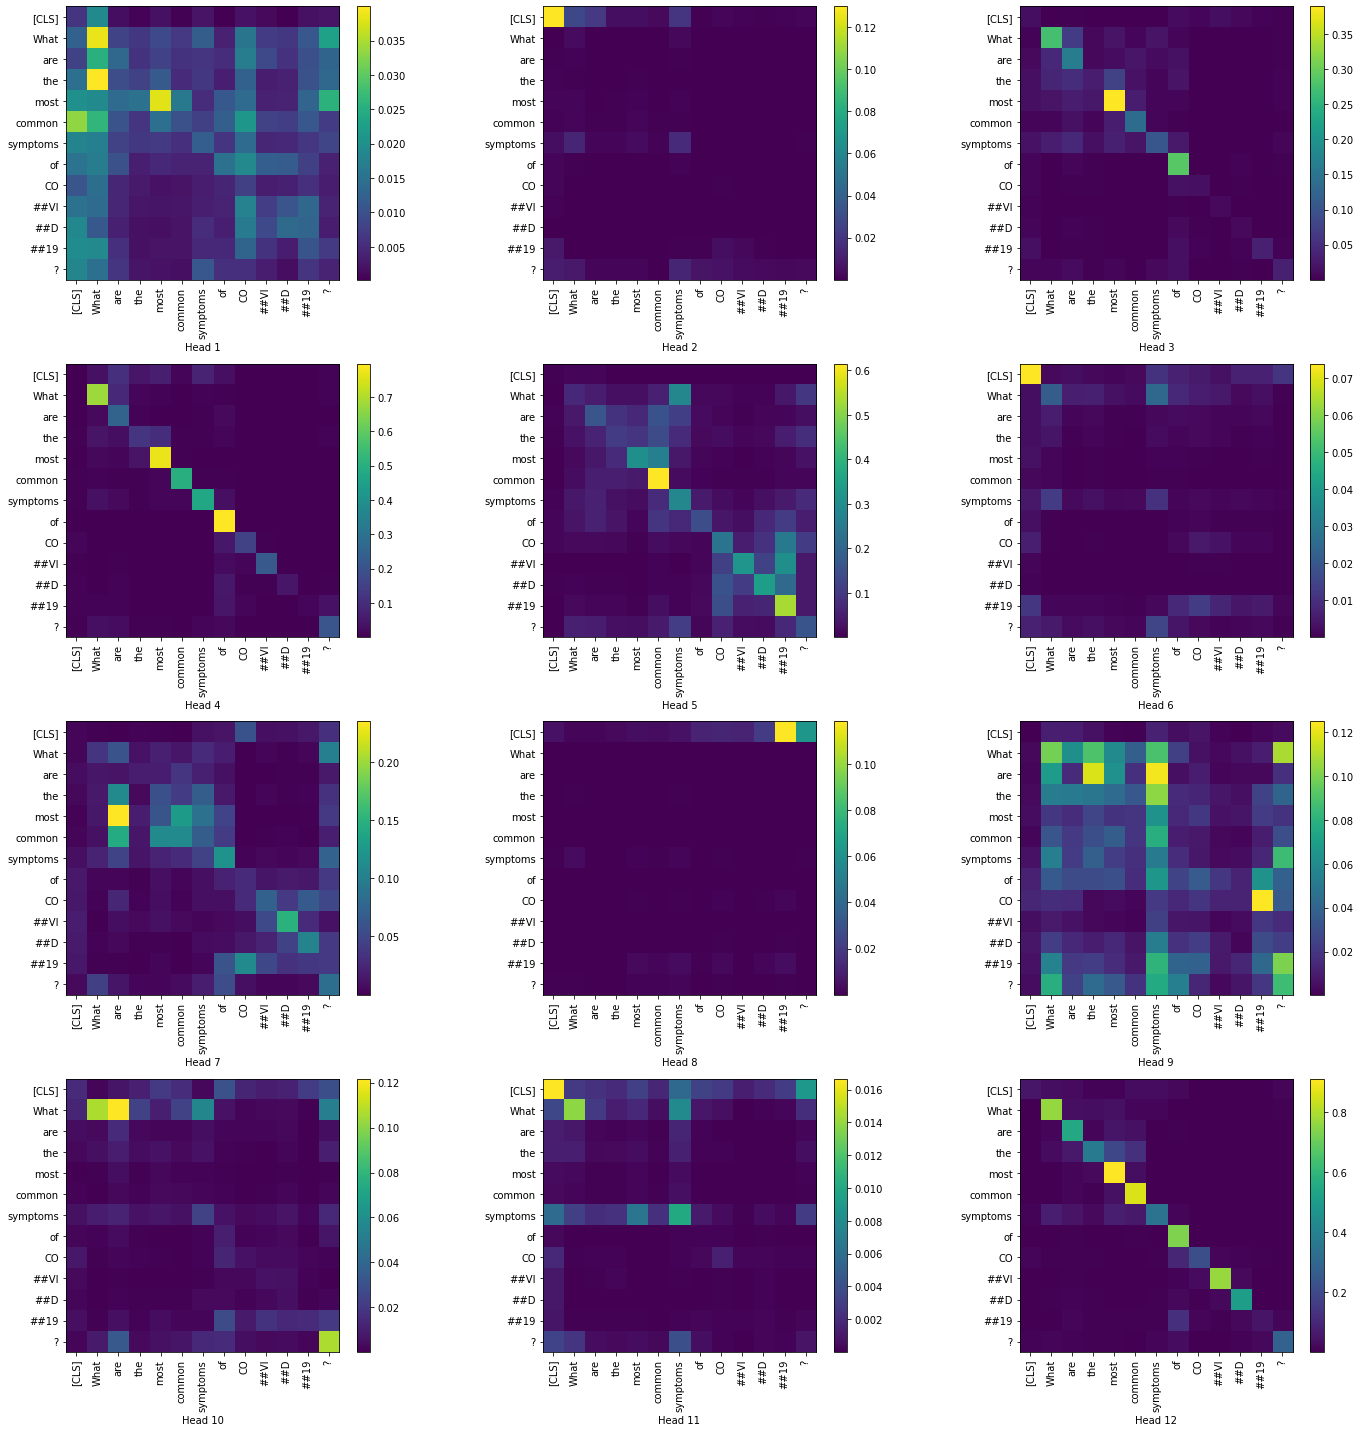

In [ ]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [ ]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [ ]:
output_attentions_all = torch.stack(attn_score_qn)

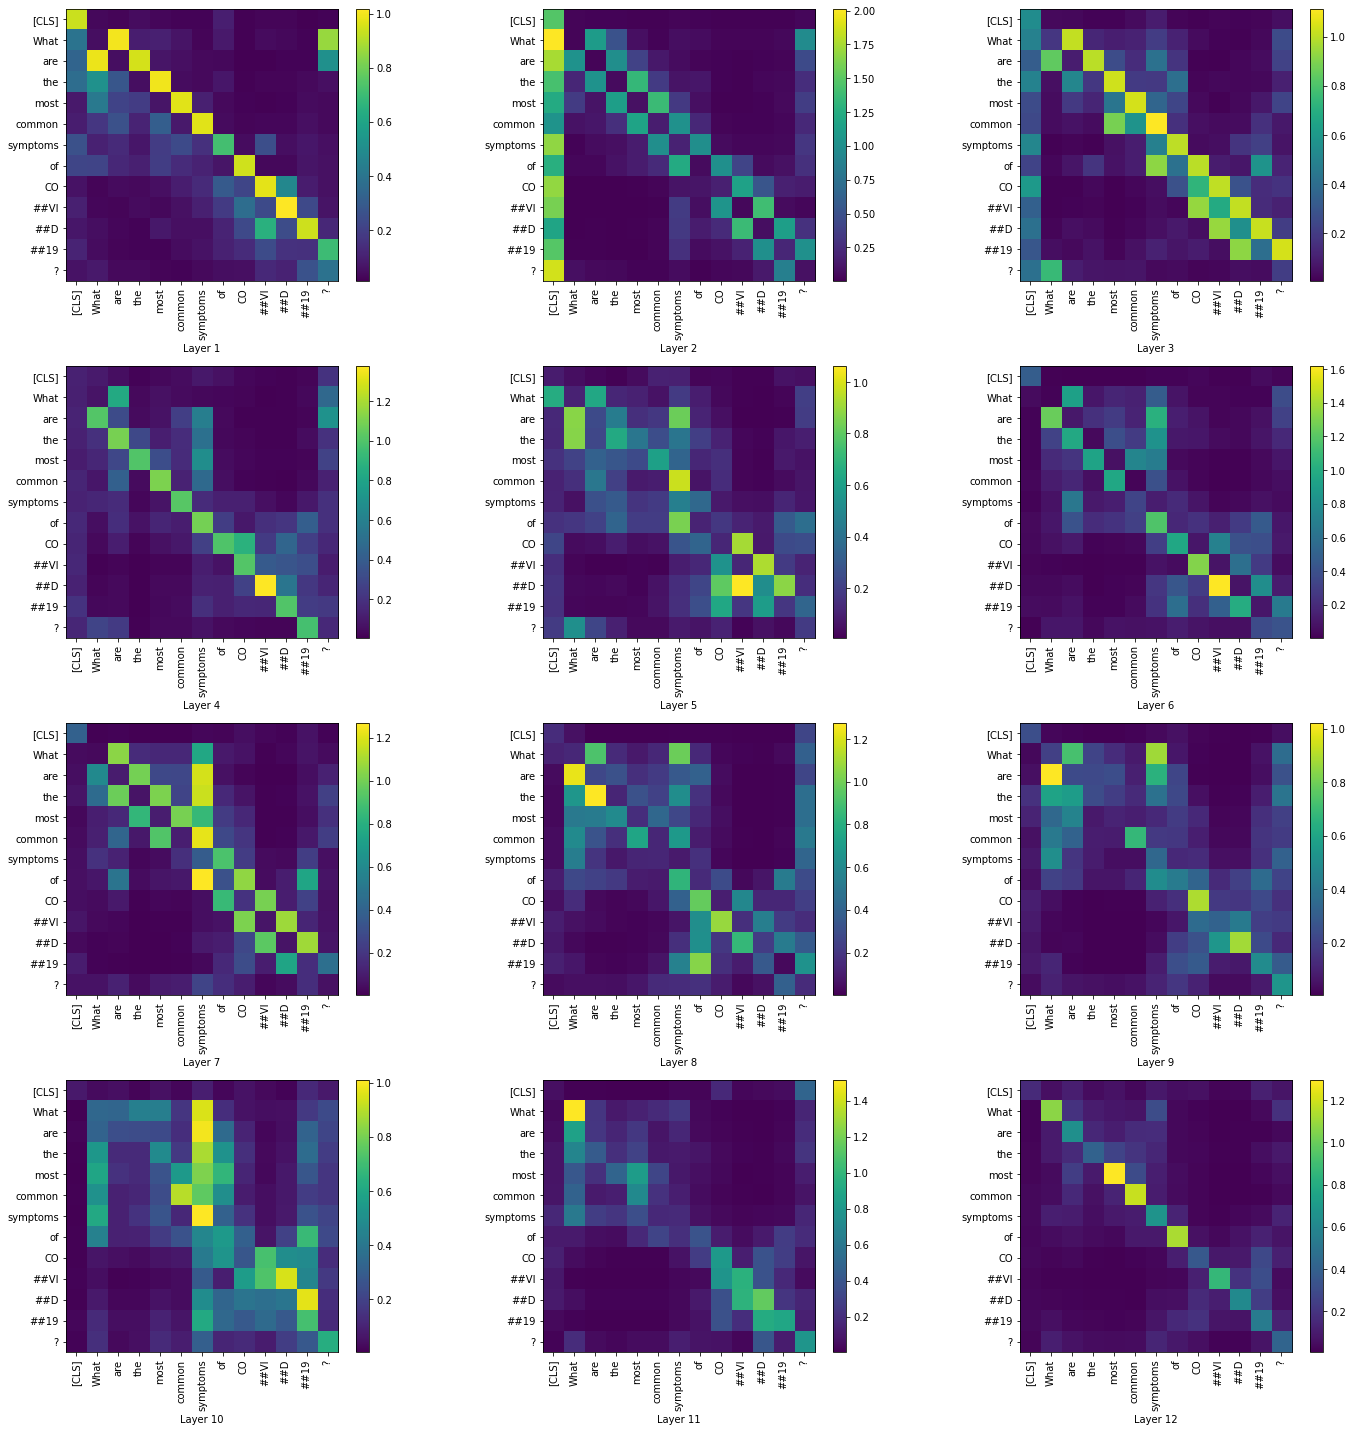

In [ ]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### Finetuning BioBERT

In [ ]:
train_data = load_dataset("covid_qa_deepset", split='train[:90%]')
val_data = load_dataset("covid_qa_deepset",split='train[90%:]') 

train_contexts, train_questions, train_answers = train_data["context"], train_data["question"], train_data["answers"]
val_contexts, val_questions, val_answers = val_data["context"], val_data["question"], val_data["answers"]

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text'][0]
        if type(answer['answer_start']) == list:
          answer['answer_start'] = answer['answer_start'][0]
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

    # return answers, contexts

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
import torch

class CovidQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = CovidQADataset(train_encodings)
val_dataset = CovidQADataset(val_encodings)

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DL_CovidQA/biobert_base_covidqa_finetuned.pt")

In [ ]:
# loading the fine-tuned model
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CovidQA/biobert_base_covidqa_finetuned.pt"))
#run_eval()

<All keys matched successfully>

### With Finetuning

In [ ]:
#answer_pred, meteor_score = run_eval()

In [ ]:
# checking for 1 question, example 1
question = val_questions_cov[10]
print(question)

What are the most common symptoms of COVID19?


In [ ]:
k = 20
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [ ]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

CO
[CLS]
the
mild hypoxemia with preserved lung compliance
What
18177 patients were hospitalized .
smell and taste loss
Re
[CLS]
d
We
What
Fever , dry cough , and exhaustion
MIS - C is not J o u r n a l P r e - p r o o f mentioned as a diagnosis but steroids were given to 7 / 17 ( 41 . 1 % ) patients . Six patients were given steroids as the inflammatory markers were high and all recovered ( 4 ) . Now coming to impact of COVID19 on non - malignant hematological conditions in children , in this issue few reports have described this aspect also ( 4 ) ( 5 ) ( 6 ) ( 7 ) ( 8 ) ( 10 ) ( 11 ) ( 12 ) . Kakkar et al . have reported a cohort of 14 patients with thalassemia and COVID19 patients of whom only 2 needed hospitalisation .
EGY
death was 6 . 053 times more likely to occur in the COVID19 group that the non - COVID19 patients . Discussion Blood group antigens are one of the most important antigens in humans that can be used as a prognosis factor in different diseases . Different studies h

In [ ]:
answer = val_answers_cov[10]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.0
0.0
0.0
0.0
0.0
0.0
0.16129032258064518
0.0
0.0
0.0
0.0
0.0
0.44117647058823534
0.031446540880503145
0.0
0.01392757660167131
0.014749262536873156
0.014749262536873156
0.16666666666666666
0.0


In [ ]:
# checking for 1 question, example 2
question = val_questions_cov[13]
print(question)

How long is the incubation time for COVID19?


In [79]:
candidate_doc = get_top_k_articles(question, segmented_docs, k)

In [80]:
ans_list = []
for i in range(len(candidate_doc)):
  ans = answer_question(model, tokenizer, question, candidate_doc[i], device)
  print(ans)
  ans_list.append(ans)

11 days
[CLS]
2 . 87 days [ 3 ] to 17 . 6 days
8 : 75
latest
9 days
2
2
7 . 1 days
6
7 . 5 days
4 . 75 days
1817
12 weeks
[CLS]
slowly over several months
two weeks
17 and 18 days
5
4 . 4 days


In [81]:
answer = val_answers_cov[13]['text'][0]
for i in range(len(ans_list)):
  print(meteor.compute(predictions=[ans_list[i]], references=[answer])['meteor'])

0.10638297872340426
0.0
0.17543859649122806
0.0
0.0
0.10638297872340426
0.10869565217391304
0.10869565217391304
0.10204081632653061
0.0
0.10204081632653061
0.10204081632653061
0.0
0.0
0.0
0.0
0.10638297872340426
0.20408163265306123
0.0
0.10204081632653061


#### Visualizing Attention - BioBERT with finetuning on COVID-QA

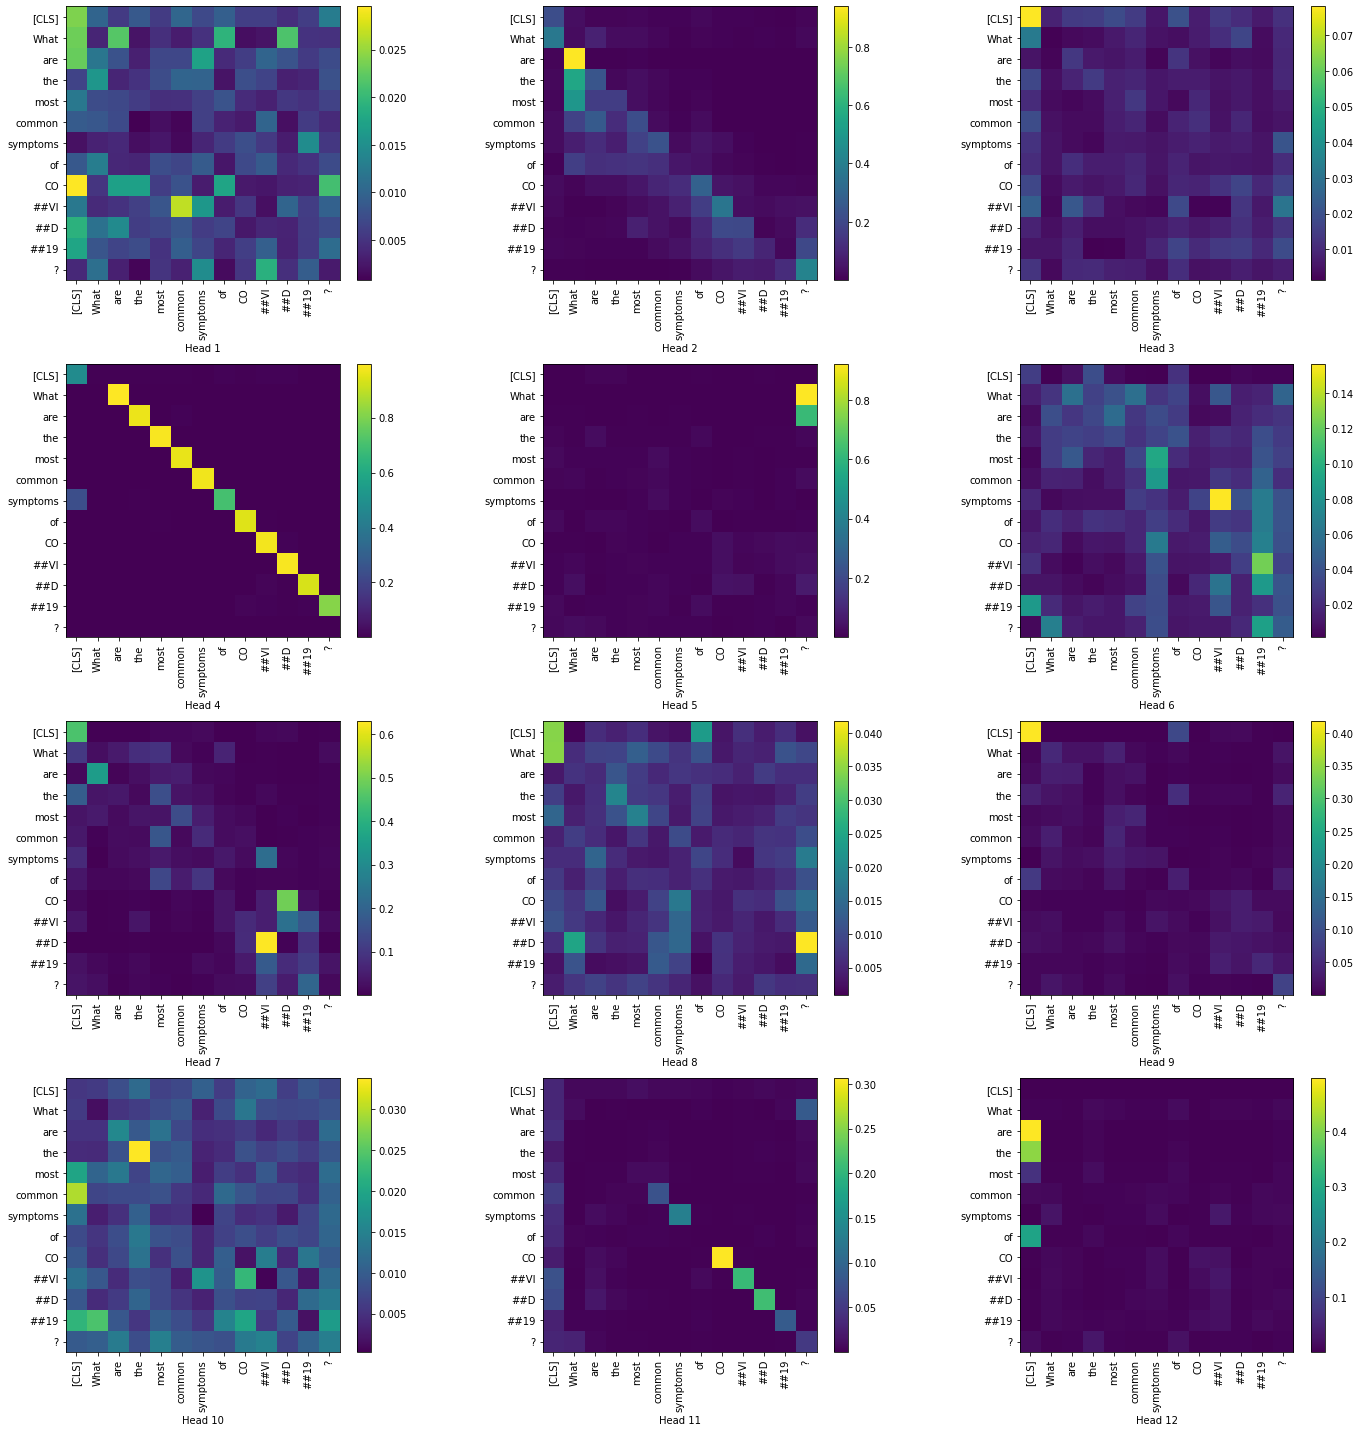

In [82]:
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], candidate_doc[12], answer, 512, tokenizer, model, device)
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

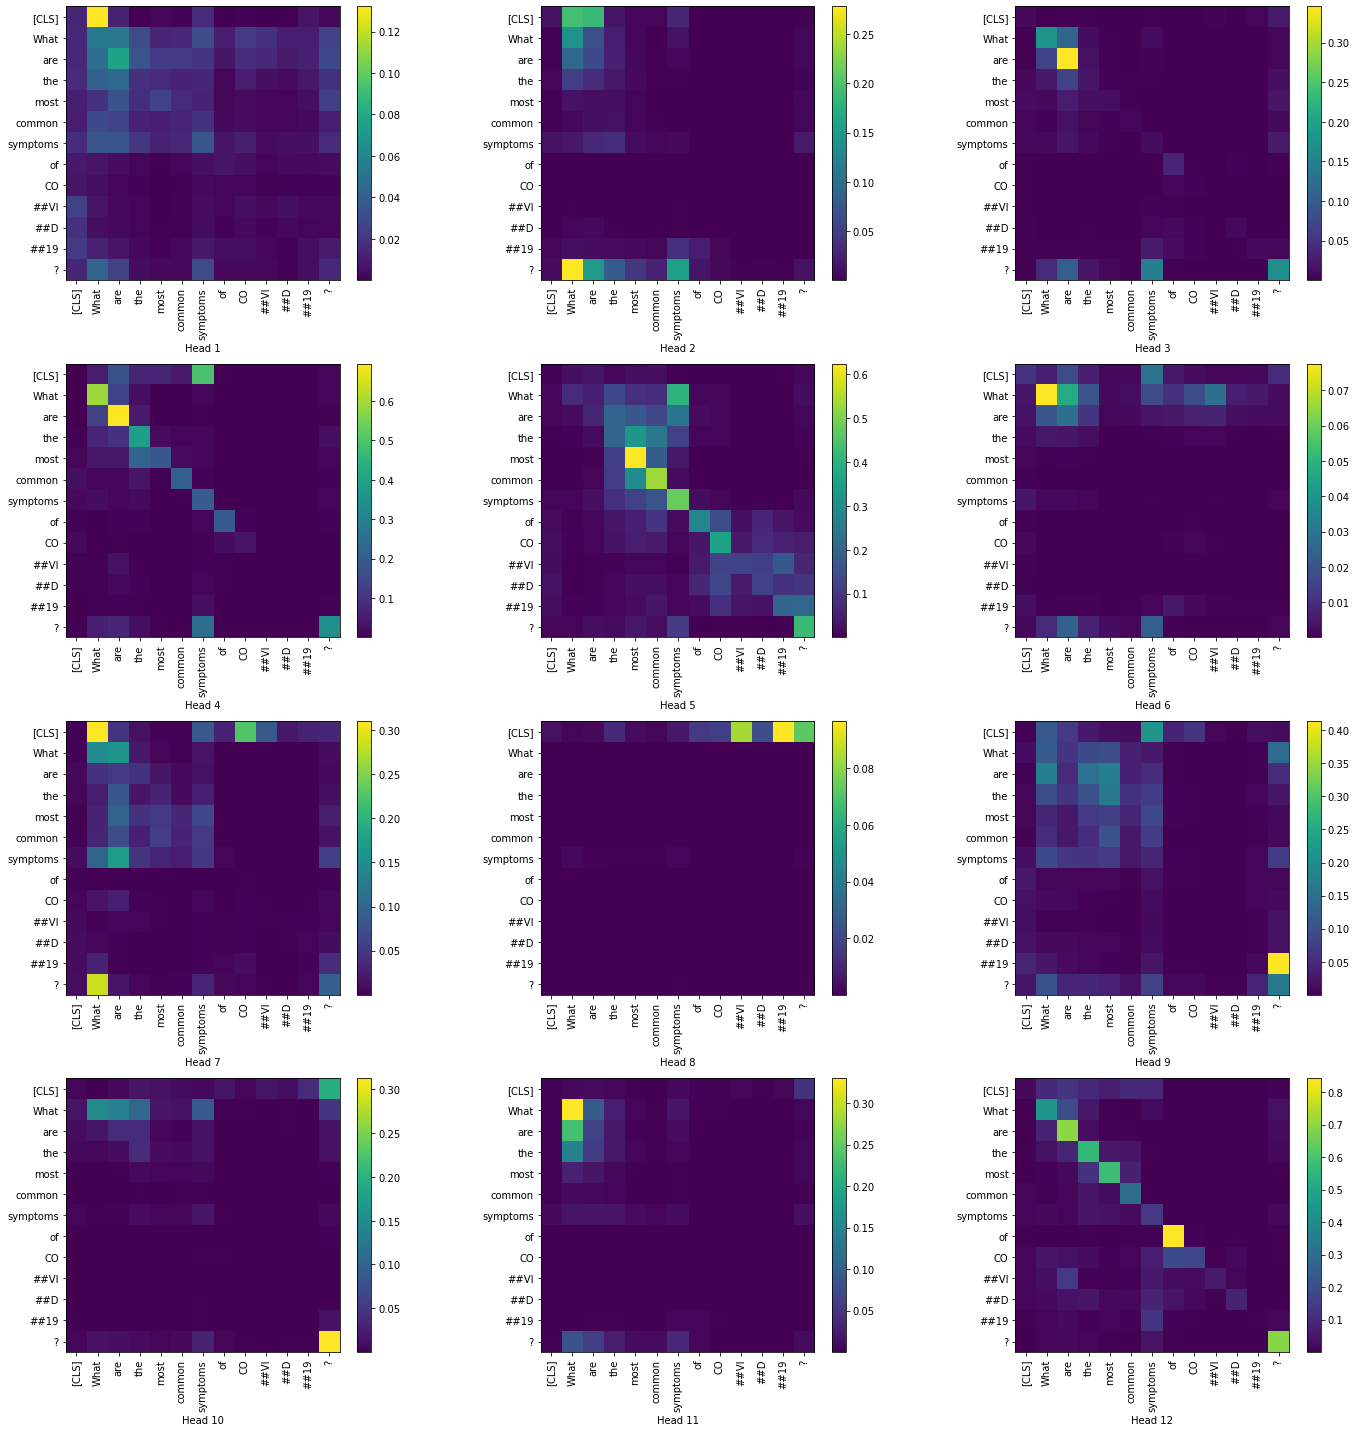

In [83]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [84]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [85]:
output_attentions_all = torch.stack(attn_score_qn)

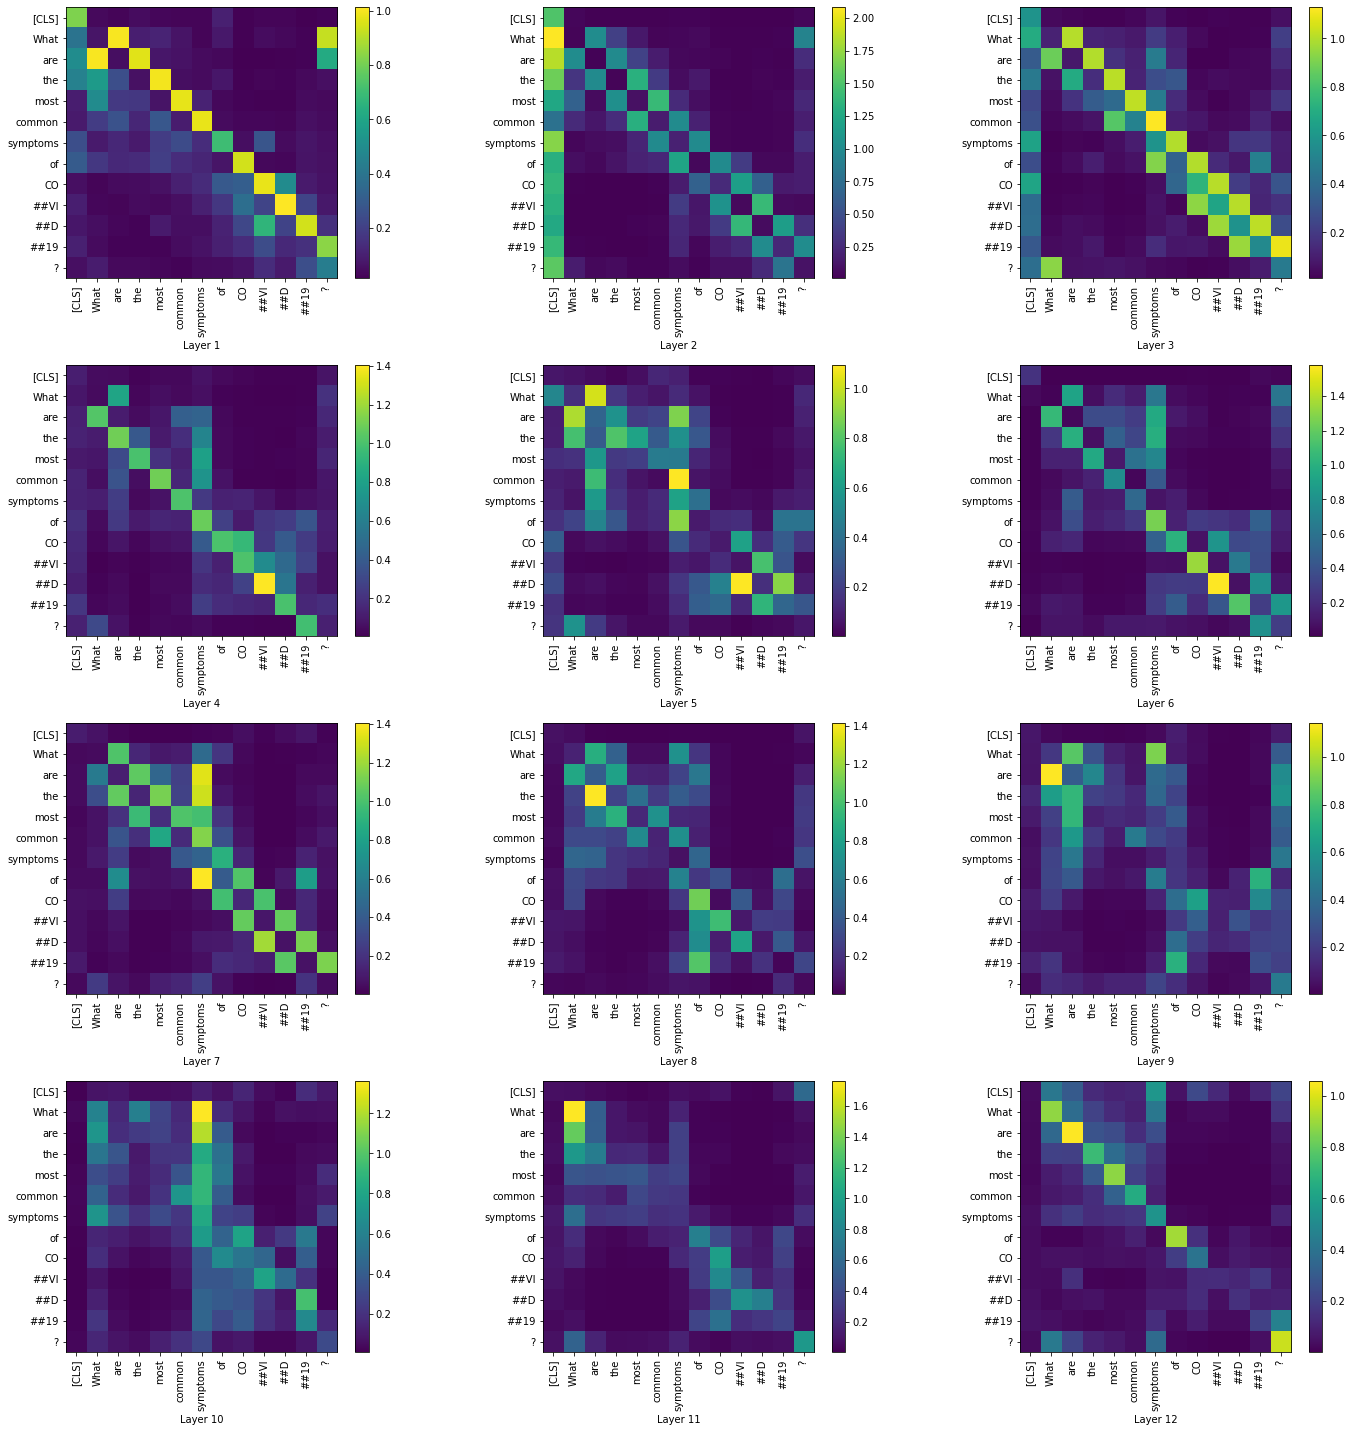

In [86]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')